# Data processing for bump hunt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *
from helpers.physics_functions import *
from helpers.data_transforms import *

plt.style.use("../science.mplstyle")


In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
project_id = "lowmass"
run_id = "trigger_12_03"
run_jet = False

working_dir = workflow["file_paths"]["working_dir"]
path_to_compiled_data = workflow["file_paths"]["data_storage_dir"]+f"/compiled_data/{project_id}"
    
codes_list = ["skimmed_data_2016H_30555_nojet"] # may want multiple codes for injection studies

uncut_data_OS, uncut_data_SS = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_SS[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data_OS[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data_OS[code][list(uncut_data_OS[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_SS[code][list(uncut_data_SS[code].keys())[0]].shape)

DATA_nojet opp sign (21803678,)
DATA_nojet same sign (6756613,)


In [ ]:
feature_set = list(uncut_data_OS[codes_list[0]].keys())
feature_set = [x for x in feature_set if "HLT" not in x]
print(feature_set)

## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

Random seed is used to set aside a portion of the test set

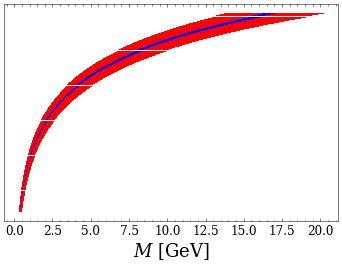

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192])


In [5]:
# define SB / SR choices

detector_resolution = 0.01
start_mass = 0.3
stop_mass = 20

current_mass = start_mass
all_bins = [start_mass]


while current_mass < stop_mass:
    loc_bin_width = current_mass*detector_resolution
    current_mass += loc_bin_width
    all_bins.append(current_mass)
    

num_bins_total = len(all_bins)

SB_num_bins = 17
SR_num_bins = 5
window_gap = 2
window_length = 2*SB_num_bins + SR_num_bins



bin_definitions = {}
    
plt.figure()

window_index = 0

for i in range(0, num_bins_total, window_gap):
    if i + window_length < num_bins_total:
        
        bin_definitions[window_index] = {"SBL":[],"SR":[], "SBH":[]}
        
        
        bin_definitions[window_index]["SBL"] = all_bins[i:i+SB_num_bins+1]
        bin_definitions[window_index]["SR"] = all_bins[i+SB_num_bins:i+SB_num_bins+SR_num_bins+1]
        bin_definitions[window_index]["SBH"] = all_bins[i+SB_num_bins+SR_num_bins:i+2*SB_num_bins+SR_num_bins+1]
        
        plt.plot(bin_definitions[window_index]["SBL"], [i for x in bin_definitions[window_index]["SBL"]], color = "red")
        plt.plot(bin_definitions[window_index]["SR"], [i for x in bin_definitions[window_index]["SR"]], color = "blue")
        plt.plot(bin_definitions[window_index]["SBH"], [i for x in bin_definitions[window_index]["SBH"]], color = "red")
        
        window_index += 1

plt.xlabel("$M$ [GeV]")
plt.yticks([])
plt.show()
    
num_windows = len(bin_definitions.keys())
print(bin_definitions.keys())
with open(f"{working_dir}/projects/{scaler_id}/processed_data/bin_definitions", "wb") as ofile:
    pickle.dump(bin_definitions, ofile)



In [6]:
cut_data_OS, cut_data_SS = {code:{} for code in codes_list},  {code:{} for code in codes_list}

pt_high_cut, pt_low_cut = 20, 10
eta_cut = 2.1


for code in codes_list:

    # define cuts

    pass_indices_OS = (uncut_data_OS[code]["mu0_pt"] >= pt_high_cut) & (uncut_data_OS[code]["mu1_pt"] >= pt_low_cut) & (np.abs(uncut_data_OS[code]["mu0_eta"]) <= eta_cut) & (np.abs(uncut_data_OS[code]["mu1_eta"]) <= eta_cut) & (uncut_data_OS[code]["dimu_mass"] <= stop_mass) & (uncut_data_OS[code][trigger])
    pass_indices_SS = (uncut_data_SS[code]["mu0_pt"] >= pt_high_cut) & (uncut_data_SS[code]["mu1_pt"] >= pt_low_cut) & (np.abs(uncut_data_SS[code]["mu0_eta"]) <= eta_cut) & (np.abs(uncut_data_SS[code]["mu1_eta"]) <= eta_cut) & (uncut_data_SS[code]["dimu_mass"] <= stop_mass) & (uncut_data_SS[code][trigger])

    # apply cuts to oppsign
    for feat in feature_set:
        cut_data_OS[code][feat] = uncut_data_OS[code][feat][pass_indices_OS]
        cut_data_SS[code][feat] = uncut_data_SS[code][feat][pass_indices_SS]
    
    print(f"{code} OS has shape {cut_data_OS[code][feat].shape} after cuts")
    print(f"{code} SS has shape {cut_data_SS[code][feat].shape} after cuts")
    
    

DATA_nojet oppsign has shape (21803678,) after cuts
DATA_nojet samesign has shape (6756613,) after cuts


Check how local cuts affect the starting significance

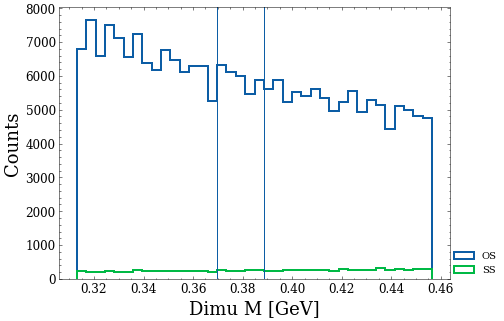

In [7]:
window_index = 2

loc_SR_left, loc_SR_right = min(bin_definitions[window_index]["SR"]), max(bin_definitions[window_index]["SR"])
loc_SB_left, loc_SB_right = min(bin_definitions[window_index]["SBL"]), max(bin_definitions[window_index]["SBH"])


plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(loc_SR_left, loc_SR_right, loc_SB_left, loc_SB_right, num_bins_SR= 6)


plt.figure(figsize = (7,5))

x = np.linspace(loc_SB_left, loc_SB_right, 100) # plot curve fit

masses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= loc_SB_left) & (cut_data[code]["dimu_mass"] <= loc_SB_right)]
masses_with_bounds_samesign = cut_data_samesign[code]["dimu_mass"][(cut_data_samesign[code]["dimu_mass"] >= loc_SB_left) & (cut_data_samesign[code]["dimu_mass"] <= loc_SB_right)]


plt.hist(masses_with_bounds, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"OS")
plt.hist(masses_with_bounds_samesign, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"SS")


plt.axvline(loc_SR_left)
plt.axvline(loc_SR_right)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

#plt.yscale("log")

plt.show()

 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


Split data into bands

In [8]:
from sklearn.preprocessing import StandardScaler

frac_events_save = 1 # save out only a portion of the events

bands = ["SBL", "SR", "SBH"]
N_total_events = 0
N_total_events_samesign = 0

for i in range(num_windows):
    
    # define SR, SB

    loc_SR_left, loc_SR_right = min(bin_definitions[i]["SR"]), max(bin_definitions[i]["SR"])
    loc_SB_left, loc_SB_right = min(bin_definitions[i]["SBL"]), max(bin_definitions[i]["SBH"])

    
    print(f"SB bounds: {loc_SB_left}, {loc_SB_right}")
    print(f"SR bounds: {loc_SR_left}, {loc_SR_right}")

    band_bounds = {"SBL": [loc_SB_left, loc_SR_left],
                       "SR": [loc_SR_left, loc_SR_right],
                       "SBH": [loc_SR_right, loc_SB_right],
                               }
    
    # split data into bands
    preproc_dicts, preproc_dicts_samesign = {b:{} for b in bands}, {b:{} for b in bands}

    for code in codes_list:
        for b in bands:

            # opp sign
            loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
            preproc_dicts[b][code] = {}
            for feat in feature_set:
                preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]
            N_total_events += preproc_dicts[b][code][feat].shape[0]

            # same sign
            loc_pass_indices_samesign = (cut_data_samesign[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_samesign[code]["dimu_mass"] < band_bounds[b][1])
            preproc_dicts_samesign[b][code] = {}
            for feat in feature_set:
                preproc_dicts_samesign[b][code][feat] = cut_data_samesign[code][feat][loc_pass_indices_samesign]
            N_total_events_samesign += preproc_dicts_samesign[b][code][feat].shape[0]

    print(f"Total events opp sign: {N_total_events}")
    print(f"Total events same sign: {N_total_events_samesign}")
    
    
    # transformed / preprocess data
    
    sizes_dict, sizes_dict_samesign = {}, {}

    proccessed_data_dict, proccessed_data_dict_samesign  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}

    for feat in feature_set: 

        # train the preprocessor on the opp sign data only
        data_SB = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)

        if feat == "dimu_mass": # don't logit transform
            mass_scaler = StandardScaler()
            mass_scaler = mass_scaler.fit(data_SB)

            with open(f"{working_dir}/projects/{scaler_id}/processed_data/mass_scaler_{i}", "wb") as ofile:
                pickle.dump(mass_scaler, ofile)
                
            

            for b in bands:
                num_events_save_band = int(len(preproc_dicts[b][sim_id][feat])*frac_events_save)
                
                proccessed_data_dict[b]["s_inj_data"][feat] = mass_scaler.transform(preproc_dicts[b][sim_id][feat][:num_events_save_band].reshape(-1,1))
                proccessed_data_dict_samesign[b]["s_inj_data"][feat] =  mass_scaler.transform(preproc_dicts_samesign[b][sim_id][feat].reshape(-1,1))
                sizes_dict[b] = proccessed_data_dict[b]["s_inj_data"][feat].shape[0]
                sizes_dict_samesign[b] = proccessed_data_dict_samesign[b]["s_inj_data"][feat].shape[0]

        else: 
            data_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat], preproc_dicts["SR"][sim_id][feat])).reshape(-1, 1)
            all_min = np.min(data_all)
            all_max = np.max(data_all)
            # logit transform the features
            transformed_feats = logit_transform(data_SB, all_min, all_max)
            # subtract off mean, std of the training set
            mean_to_sub = np.mean(transformed_feats)
            std_to_sub = np.std(transformed_feats)
            
            

            for b in bands:
                num_events_save_band = int(len(preproc_dicts[b][sim_id][feat])*frac_events_save)
                proccessed_data_dict[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts[b][sim_id][feat][:num_events_save_band], all_min, all_max) - mean_to_sub)/std_to_sub
                proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_samesign[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub

    print(sizes_dict)
    print(sizes_dict_samesign)

    
    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{i}_nojet_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict, ofile)

    
    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{i}_samesign_nojet_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict_samesign, ofile)


    print()


SB bounds: 0.3, 0.44223675255095657
SR bounds: 0.3552913294118806, 0.3734147579252762
Total events opp sign: 231276
Total events same sign: 9164
{'SBL': 102865, 'SR': 29066, 'SBH': 99345}
{'SBL': 3236, 'SR': 1145, 'SBH': 4783}

SB bounds: 0.30602999999999997, 0.4511257112772308
SR bounds: 0.3624326851330594, 0.3809203945595742


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 462776
Total events same sign: 18704
{'SBL': 103319, 'SR': 29451, 'SBH': 98730}
{'SBL': 3407, 'SR': 1182, 'SBH': 4951}

SB bounds: 0.31218120299999996, 0.4601933380739031
SR bounds: 0.36971758210423383, 0.38857689449022165


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 692717
Total events same sign: 28512
{'SBL': 101638, 'SR': 29820, 'SBH': 98483}
{'SBL': 3447, 'SR': 1262, 'SBH': 5099}

SB bounds: 0.31845604518029996, 0.4694432241691886
SR bounds: 0.37714890550452895, 0.3963872900694751


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 922400
Total events same sign: 38656
{'SBL': 102047, 'SR': 29188, 'SBH': 98448}
{'SBL': 3572, 'SR': 1256, 'SBH': 5316}

SB bounds: 0.32485701168842396, 0.47887903297498924
SR bounds: 0.38472959850516997, 0.40435467459987157


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1150464
Total events same sign: 49111
{'SBL': 100408, 'SR': 29179, 'SBH': 98477}
{'SBL': 3699, 'SR': 1347, 'SBH': 5409}

SB bounds: 0.3313866376233613, 0.4885045015377865
SR bounds: 0.39246266343512387, 0.41248220355932896


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1378331
Total events same sign: 59941
{'SBL': 99986, 'SR': 29302, 'SBH': 98579}
{'SBL': 3843, 'SR': 1391, 'SBH': 5596}

SB bounds: 0.33804750903959085, 0.498323442018696
SR bounds: 0.40035116297016987, 0.42077309585087147


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1605846
Total events same sign: 71063
{'SBL': 99982, 'SR': 28662, 'SBH': 98871}
{'SBL': 3997, 'SR': 1413, 'SBH': 5712}

SB bounds: 0.34484226397128664, 0.5083397432032718
SR bounds: 0.4083982213458703, 0.429230635077474


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1833925
Total events same sign: 82582
{'SBL': 99909, 'SR': 29069, 'SBH': 99101}
{'SBL': 4128, 'SR': 1463, 'SBH': 5928}

SB bounds: 0.35177359347710946, 0.5185573720416575
SR bounds: 0.41660702559492224, 0.43785817084253126


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 2061921
Total events same sign: 94514
{'SBL': 99640, 'SR': 29357, 'SBH': 98999}
{'SBL': 4305, 'SR': 1545, 'SBH': 6082}

SB bounds: 0.3588442427059994, 0.5289803752196949
SR bounds: 0.4249808268093802, 0.44665912007646613


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 2290242
Total events same sign: 106771
{'SBL': 99519, 'SR': 29098, 'SBH': 99704}
{'SBL': 4456, 'SR': 1617, 'SBH': 6184}

SB bounds: 0.36605701198438995, 0.5396128807616107
SR bounds: 0.43352294142824876, 0.45563696839000306


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 2518857
Total events same sign: 119349
{'SBL': 99246, 'SR': 28664, 'SBH': 100705}
{'SBL': 4588, 'SR': 1671, 'SBH': 6319}

SB bounds: 0.3734147579252762, 0.5504590996649191
SR bounds: 0.44223675255095657, 0.46479527145464217


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 2749438
Total events same sign: 132316
{'SBL': 99345, 'SR': 28611, 'SBH': 102625}
{'SBL': 4783, 'SR': 1688, 'SBH': 6496}

SB bounds: 0.3809203945595742, 0.561523327568184
SR bounds: 0.4511257112772308, 0.47413765641088046


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 2981040
Total events same sign: 145670
{'SBL': 98730, 'SR': 28804, 'SBH': 104068}
{'SBL': 4951, 'SR': 1724, 'SBH': 6679}

SB bounds: 0.38857689449022165, 0.5728099464523044
SR bounds: 0.4601933380739031, 0.4836678233047391
Total events opp sign: 3213884
Total events same sign: 159438
{'SBL': 98483, 'SR': 28991, 'SBH': 105370}
{'SBL': 5099, 'SR': 1752, 'SBH': 6917}

SB bounds: 0.3963872900694751, 0.5843234263759958
SR bounds: 0.4694432241691886, 0.49338954655316436


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 3448197
Total events same sign: 173603
{'SBL': 98448, 'SR': 29304, 'SBH': 106561}
{'SBL': 5316, 'SR': 1759, 'SBH': 7090}

SB bounds: 0.40435467459987157, 0.5960683272461533
SR bounds: 0.47887903297498924, 0.5033066764388829


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 3683856
Total events same sign: 188141
{'SBL': 98477, 'SR': 29562, 'SBH': 107620}
{'SBL': 5409, 'SR': 1806, 'SBH': 7323}

SB bounds: 0.41248220355932896, 0.608049300623801
SR bounds: 0.4885045015377865, 0.5134231406353045


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 3921150
Total events same sign: 203133
{'SBL': 98579, 'SR': 29388, 'SBH': 109327}
{'SBL': 5596, 'SR': 1905, 'SBH': 7491}

SB bounds: 0.42077309585087147, 0.6202710915663394
SR bounds: 0.498323442018696, 0.5237429457620741


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 4160371
Total events same sign: 218527
{'SBL': 98871, 'SR': 29699, 'SBH': 110651}
{'SBL': 5712, 'SR': 1988, 'SBH': 7694}

SB bounds: 0.429230635077474, 0.6327385405068229
SR bounds: 0.5083397432032718, 0.5342701789718918


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 4401615
Total events same sign: 234293
{'SBL': 99101, 'SR': 29887, 'SBH': 112256}
{'SBL': 5928, 'SR': 1967, 'SBH': 7871}

SB bounds: 0.43785817084253126, 0.64545658517101
SR bounds: 0.5185573720416575, 0.5450090095692268


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 4645335
Total events same sign: 250468
{'SBL': 98999, 'SR': 31290, 'SBH': 113431}
{'SBL': 6082, 'SR': 1991, 'SBH': 8102}

SB bounds: 0.44665912007646613, 0.6584302625329473
SR bounds: 0.5289803752196949, 0.5559636906615684
Total events opp sign: 4891936
Total events same sign: 267089
{'SBL': 99704, 'SR': 32698, 'SBH': 114199}
{'SBL': 6184, 'SR': 2094, 'SBH': 8343}

SB bounds: 0.45563696839000306, 0.6716647108098596
SR bounds: 0.5396128807616107, 0.5671385608438658


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 5142003
Total events same sign: 284168
{'SBL': 100705, 'SR': 32992, 'SBH': 116370}
{'SBL': 6319, 'SR': 2186, 'SBH': 8574}

SB bounds: 0.46479527145464217, 0.6851651714971377
SR bounds: 0.5504590996649191, 0.5785380459168274


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 5395982
Total events same sign: 301669


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 102625, 'SR': 32498, 'SBH': 118856}
{'SBL': 6496, 'SR': 2259, 'SBH': 8746}

SB bounds: 0.47413765641088046, 0.6989369914442302
SR bounds: 0.561523327568184, 0.5901666606397558
Total events opp sign: 5654146
Total events same sign: 319675
{'SBL': 104068, 'SR': 32441, 'SBH': 121655}
{'SBL': 6679, 'SR': 2271, 'SBH': 9056}

SB bounds: 0.4836678233047391, 0.7129856249722593
SR bounds: 0.5728099464523044, 0.6020290105186149


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 5917406
Total events same sign: 338243
{'SBL': 105370, 'SR': 32777, 'SBH': 125113}
{'SBL': 6917, 'SR': 2368, 'SBH': 9283}

SB bounds: 0.49338954655316436, 0.7273166360342017
SR bounds: 0.5843234263759958, 0.6141297936300391


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 6185552
Total events same sign: 357286
{'SBL': 106561, 'SR': 32971, 'SBH': 128614}
{'SBL': 7090, 'SR': 2473, 'SBH': 9480}

SB bounds: 0.5033066764388829, 0.7419357004184892
SR bounds: 0.5960683272461533, 0.6264738024820028


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 6460027
Total events same sign: 376935
{'SBL': 107620, 'SR': 33738, 'SBH': 133117}
{'SBL': 7323, 'SR': 2494, 'SBH': 9832}

SB bounds: 0.5134231406353045, 0.7568486079969009
SR bounds: 0.608049300623801, 0.6390659259118912


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 6743088
Total events same sign: 397005
{'SBL': 109327, 'SR': 34381, 'SBH': 139353}
{'SBL': 7491, 'SR': 2512, 'SBH': 10067}

SB bounds: 0.5237429457620741, 0.7720612650176386
SR bounds: 0.6202710915663394, 0.6519111510227201


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 7039606
Total events same sign: 417615
{'SBL': 110651, 'SR': 35054, 'SBH': 150813}
{'SBL': 7694, 'SR': 2587, 'SBH': 10329}

SB bounds: 0.5342701789718918, 0.7875796964444932
SR bounds: 0.6327385405068229, 0.6650145651582768


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 7357809
Total events same sign: 438809
{'SBL': 112256, 'SR': 36237, 'SBH': 169710}
{'SBL': 7871, 'SR': 2726, 'SBH': 10597}

SB bounds: 0.5450090095692268, 0.8034100483430275
SR bounds: 0.64545658517101, 0.6783813579179582


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 7690696
Total events same sign: 460524
{'SBL': 113431, 'SR': 36961, 'SBH': 182495}
{'SBL': 8102, 'SR': 2795, 'SBH': 10818}

SB bounds: 0.5559636906615684, 0.8195585903147223
SR bounds: 0.6584302625329473, 0.6920168232121091


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 8031064
Total events same sign: 482855
{'SBL': 114199, 'SR': 38286, 'SBH': 187883}
{'SBL': 8343, 'SR': 2840, 'SBH': 11148}

SB bounds: 0.5671385608438658, 0.8360317179800482
SR bounds: 0.6716647108098596, 0.7059263613586725
Total events opp sign: 8378377
Total events same sign: 505750
{'SBL': 116370, 'SR': 39444, 'SBH': 191499}
{'SBL': 8574, 'SR': 2900, 'SBH': 11421}

SB bounds: 0.5785380459168274, 0.8528359555114471
SR bounds: 0.6851651714971377, 0.7201154812219819
Total events opp sign: 8732055
Total events same sign: 529107
{'SBL': 118856, 'SR': 40690, 'SBH': 194132}
{'SBL': 8746, 'SR': 3033, 'SBH': 11578}

SB bounds: 0.5901666606397558, 0.8699779582172271
SR bounds: 0.6989369914442302, 0.7345898023945437
Total events opp sign: 9092107
Total events same sign: 553078
{'SBL': 121655, 'SR': 42580, 'SBH': 195817}
{'SBL': 9056, 'SR': 3104, 'SBH': 11811}

SB bounds: 0.6020290105186149, 0.8874645151773934
SR bounds: 0.7129856249722593, 0.7493550574226742
Total events

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 12758695
Total events same sign: 795280
{'SBL': 191499, 'SR': 48506, 'SBH': 248125}
{'SBL': 11421, 'SR': 3645, 'SBH': 14329}

SB bounds: 0.7201154812219819, 1.061538439590929
SR bounds: 0.8528359555114471, 0.8963391603291674


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 13264466
Total events same sign: 825333
{'SBL': 194132, 'SR': 49313, 'SBH': 262326}
{'SBL': 11578, 'SR': 3796, 'SBH': 14679}

SB bounds: 0.7345898023945437, 1.0828753622267069
SR bounds: 0.8699779582172271, 0.9143555774517836
Total events opp sign: 13783869
Total events same sign: 856032
{'SBL': 195817, 'SR': 50107, 'SBH': 273479}
{'SBL': 11811, 'SR': 3912, 'SBH': 14976}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 0.7493550574226742, 1.1046411570074637
SR bounds: 0.8874645151773934, 0.9327341245585645
Total events opp sign: 14316275
Total events same sign: 887374
{'SBL': 196746, 'SR': 51236, 'SBH': 284424}
{'SBL': 12028, 'SR': 4035, 'SBH': 15279}

SB bounds: 0.7644170940768699, 1.1268444442633136
SR bounds: 0.905302551932459, 0.9514820804621916


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 14858565
Total events same sign: 919343
{'SBL': 194822, 'SR': 52388, 'SBH': 295080}
{'SBL': 12277, 'SR': 4084, 'SBH': 15608}

SB bounds: 0.779781877667815, 1.1494940175930064
SR bounds: 0.9234991332263015, 0.9706068702794817


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 15403122
Total events same sign: 951933
{'SBL': 184974, 'SR': 54602, 'SBH': 304981}
{'SBL': 12552, 'SR': 4151, 'SBH': 15887}

SB bounds: 0.7954554934089382, 1.1725988473466258
SR bounds: 0.9420614658041502, 0.9901160683720992


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 15948681
Total events same sign: 985201
{'SBL': 173923, 'SR': 58169, 'SBH': 313467}
{'SBL': 12824, 'SR': 4289, 'SBH': 16155}

SB bounds: 0.8114441488264578, 1.196168084178293
SR bounds: 0.9609969012668136, 1.0100174013463785


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 16504691
Total events same sign: 1019124


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 171876, 'SR': 74386, 'SBH': 309748}
{'SBL': 13068, 'SR': 4431, 'SBH': 16424}

SB bounds: 0.8277541762178695, 1.2202110626702765
SR bounds: 0.9803129389822764, 1.0303187511134408
Total events opp sign: 17075634
Total events same sign: 1053626
{'SBL': 175572, 'SR': 108668, 'SBH': 286703}
{'SBL': 13364, 'SR': 4450, 'SBH': 16688}

SB bounds: 0.8443920351598486, 1.244737305029949
SR bounds: 1.0000172290558202, 1.051028158010821


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 17662890
Total events same sign: 1088796
{'SBL': 184754, 'SR': 120401, 'SBH': 282101}
{'SBL': 13680, 'SR': 4495, 'SBH': 16995}

SB bounds: 0.8613643150665615, 1.269756524861051
SR bounds: 1.0201175753598424, 1.0721538239868385


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 18267271
Total events same sign: 1124685
{'SBL': 216950, 'SR': 100829, 'SBH': 286602}
{'SBL': 14057, 'SR': 4633, 'SBH': 17199}

SB bounds: 0.8786777377993994, 1.295278631010758
SR bounds: 1.0406219386245752, 1.093704115848974


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 18889817
Total events same sign: 1161277
{'SBL': 248125, 'SR': 81636, 'SBH': 292785}
{'SBL': 14329, 'SR': 4768, 'SBH': 17495}

SB bounds: 0.8963391603291674, 1.3213137314940742
SR bounds: 1.061538439590929, 1.1156875685775383


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 19531200
Total events same sign: 1198564
{'SBL': 262326, 'SR': 78909, 'SBH': 300148}
{'SBL': 14679, 'SR': 4875, 'SBH': 17733}

SB bounds: 0.9143555774517836, 1.347872137497105
SR bounds: 1.0828753622267069, 1.1381128887059468


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 20191833
Total events same sign: 1236558
{'SBL': 273479, 'SR': 79908, 'SBH': 307246}
{'SBL': 14976, 'SR': 4880, 'SBH': 18138}

SB bounds: 0.9327341245585645, 1.3749643674607968
SR bounds: 1.1046411570074637, 1.1609889577689365
Total events opp sign: 20872145
Total events same sign: 1275375
{'SBL': 284424, 'SR': 81172, 'SBH': 314716}
{'SBL': 15279, 'SR': 4949, 'SBH': 18589}

SB bounds: 0.9514820804621916, 1.4026011512467589
SR bounds: 1.1268444442633136, 1.184324835820092


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 21572044
Total events same sign: 1314994
{'SBL': 295080, 'SR': 82907, 'SBH': 321912}
{'SBL': 15608, 'SR': 5041, 'SBH': 18970}

SB bounds: 0.9706068702794817, 1.4307934343868187
SR bounds: 1.1494940175930064, 1.2081297650200757


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 22291352
Total events same sign: 1355380


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 304981, 'SR': 84921, 'SBH': 329406}
{'SBL': 15887, 'SR': 5074, 'SBH': 19425}

SB bounds: 0.9901160683720992, 1.4595523824179937
SR bounds: 1.1725988473466258, 1.2324131732969792
Total events opp sign: 23029069
Total events same sign: 1396544
{'SBL': 313467, 'SR': 86864, 'SBH': 337386}
{'SBL': 16155, 'SR': 5189, 'SBH': 19820}

SB bounds: 1.0100174013463785, 1.4888893853045952
SR bounds: 1.196168084178293, 1.2571846780802485


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 23772849
Total events same sign: 1438536
{'SBL': 309748, 'SR': 88621, 'SBH': 345411}
{'SBL': 16424, 'SR': 5185, 'SBH': 20383}

SB bounds: 1.0303187511134408, 1.5188160619492177
SR bounds: 1.2202110626702765, 1.2824540901096615


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 24503766
Total events same sign: 1481388
{'SBL': 286703, 'SR': 91134, 'SBH': 353080}
{'SBL': 16688, 'SR': 5309, 'SBH': 20855}

SB bounds: 1.051028158010821, 1.549344264794397
SR bounds: 1.244737305029949, 1.3082314173208656


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 25240027
Total events same sign: 1525059
{'SBL': 282101, 'SR': 93694, 'SBH': 360466}
{'SBL': 16995, 'SR': 5474, 'SBH': 21202}

SB bounds: 1.0721538239868385, 1.5804860845167643
SR bounds: 1.269756524861051, 1.3345268688090148


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 25991024
Total events same sign: 1569472
{'SBL': 286602, 'SR': 96253, 'SBH': 368142}
{'SBL': 17199, 'SR': 5619, 'SBH': 21595}

SB bounds: 1.093704115848974, 1.6122538548155514
SR bounds: 1.295278631010758, 1.361350858872076


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 26758071
Total events same sign: 1614777
{'SBL': 292785, 'SR': 98634, 'SBH': 375628}
{'SBL': 17495, 'SR': 5768, 'SBH': 22042}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.1156875685775383, 1.644660157297344
SR bounds: 1.3213137314940742, 1.3887140111354048
Total events opp sign: 27541786
Total events same sign: 1660920
{'SBL': 300148, 'SR': 100264, 'SBH': 383303}
{'SBL': 17733, 'SR': 5990, 'SBH': 22420}

SB bounds: 1.1381128887059468, 1.6777178264590207
SR bounds: 1.347872137497105, 1.4166271627592264


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 28342256
Total events same sign: 1708158
{'SBL': 307246, 'SR': 102461, 'SBH': 390763}
{'SBL': 18138, 'SR': 6113, 'SBH': 22987}

SB bounds: 1.1609889577689365, 1.711439954770847
SR bounds: 1.3749643674607968, 1.4451013687306868


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 29159348
Total events same sign: 1756438
{'SBL': 314716, 'SR': 104618, 'SBH': 397758}
{'SBL': 18589, 'SR': 6161, 'SBH': 23530}

SB bounds: 1.184324835820092, 1.745839897861741
SR bounds: 1.4026011512467589, 1.4741479062421736


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 29993089
Total events same sign: 1805738
{'SBL': 321912, 'SR': 107243, 'SBH': 404586}
{'SBL': 18970, 'SR': 6297, 'SBH': 24033}

SB bounds: 1.2081297650200757, 1.7809312798087622
SR bounds: 1.4307934343868187, 1.5037782791576413


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 30843488
Total events same sign: 1856099
{'SBL': 329406, 'SR': 109802, 'SBH': 411191}
{'SBL': 19425, 'SR': 6490, 'SBH': 24446}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.2324131732969792, 1.8167279985329183
SR bounds: 1.4595523824179937, 1.5340042225687098
Total events opp sign: 31711491
Total events same sign: 1907491
{'SBL': 337386, 'SR': 111798, 'SBH': 418819}
{'SBL': 19820, 'SR': 6569, 'SBH': 25003}

SB bounds: 1.2571846780802485, 1.85324423130343
SR bounds: 1.4888893853045952, 1.564837707442341


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 32596380
Total events same sign: 1959988
{'SBL': 345411, 'SR': 113870, 'SBH': 425608}
{'SBL': 20383, 'SR': 6566, 'SBH': 25548}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.2824540901096615, 1.890494440352629
SR bounds: 1.5188160619492177, 1.596290945361932
Total events opp sign: 33497368
Total events same sign: 2013529
{'SBL': 353080, 'SR': 116011, 'SBH': 431897}
{'SBL': 20855, 'SR': 6727, 'SBH': 25959}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.3082314173208656, 1.9284933786037168
SR bounds: 1.549344264794397, 1.628376393363707
Total events opp sign: 34414626
Total events same sign: 2068049


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 360466, 'SR': 118362, 'SBH': 438430}
{'SBL': 21202, 'SR': 6858, 'SBH': 26460}

SB bounds: 1.3345268688090148, 1.9672560955136515
SR bounds: 1.5804860845167643, 1.6611067588703174
Total events opp sign: 35347720
Total events same sign: 2123652


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 368142, 'SR': 120117, 'SBH': 444835}
{'SBL': 21595, 'SR': 7123, 'SBH': 26885}

SB bounds: 1.361350858872076, 2.006797943033476
SR bounds: 1.6122538548155514, 1.694495004723611
Total events opp sign: 36296318
Total events same sign: 2180419
{'SBL': 375628, 'SR': 122228, 'SBH': 450742}
{'SBL': 22042, 'SR': 7377, 'SBH': 27348}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.3887140111354048, 2.0471345816884488
SR bounds: 1.644660157297344, 1.7285543543185555
Total events opp sign: 37260335
Total events same sign: 2238130
{'SBL': 383303, 'SR': 123863, 'SBH': 456851}
{'SBL': 22420, 'SR': 7592, 'SBH': 27699}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.4166271627592264, 2.0882819867803866
SR bounds: 1.6777178264590207, 1.7632982968403585
Total events opp sign: 38238988
Total events same sign: 2296852
{'SBL': 390763, 'SR': 125367, 'SBH': 462523}
{'SBL': 22987, 'SR': 7609, 'SBH': 28126}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.4451013687306868, 2.1302564547146723
SR bounds: 1.711439954770847, 1.7987405926068498
Total events opp sign: 39231728
Total events same sign: 2356645
{'SBL': 397758, 'SR': 128100, 'SBH': 466882}
{'SBL': 23530, 'SR': 7716, 'SBH': 28547}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.4741479062421736, 2.1730746094544373
SR bounds: 1.745839897861741, 1.8348952785182475
Total events opp sign: 40237390
Total events same sign: 2417447
{'SBL': 404586, 'SR': 130428, 'SBH': 470648}
{'SBL': 24033, 'SR': 7818, 'SBH': 28951}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.5037782791576413, 2.2167534091044714
SR bounds: 1.7809312798087622, 1.8717766736164643
Total events opp sign: 41254636
Total events same sign: 2479157
{'SBL': 411191, 'SR': 132517, 'SBH': 473538}
{'SBL': 24446, 'SR': 7875, 'SBH': 29389}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.5340042225687098, 2.2613101526274715
SR bounds: 1.8167279985329183, 1.9093993847561552
Total events opp sign: 42283598
Total events same sign: 2541985
{'SBL': 418819, 'SR': 133843, 'SBH': 476300}
{'SBL': 25003, 'SR': 7979, 'SBH': 29846}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.564837707442341, 2.3067624866952836
SR bounds: 1.85324423130343, 1.947778312389754
Total events opp sign: 43322321
Total events same sign: 2605943
{'SBL': 425608, 'SR': 135245, 'SBH': 477870}
{'SBL': 25548, 'SR': 8114, 'SBH': 30296}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.596290945361932, 2.353128412677859
SR bounds: 1.890494440352629, 1.986928656468788
Total events opp sign: 44369677
Total events same sign: 2670884
{'SBL': 431897, 'SR': 137206, 'SBH': 478253}
{'SBL': 25959, 'SR': 8441, 'SBH': 30541}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 1.628376393363707, 2.400426293772684
SR bounds: 1.9284933786037168, 2.0268659224638106
Total events opp sign: 45424558
Total events same sign: 2736925
{'SBL': 438430, 'SR': 138596, 'SBH': 477855}
{'SBL': 26460, 'SR': 8634, 'SBH': 30947}

SB bounds: 1.6611067588703174, 2.4486748622775147
SR bounds: 1.9672560955136515, 2.0676059275053333
Total events opp sign: 46485804
Total events same sign: 2803940
{'SBL': 444835, 'SR': 139603, 'SBH': 476808}
{'SBL': 26885, 'SR': 8624, 'SBH': 31506}

SB bounds: 1.694495004723611, 2.497893227009293
SR bounds: 2.006797943033476, 2.1091648066481903
Total events opp sign: 47550680
Total events same sign: 2871858
{'SBL': 450742, 'SR': 140581, 'SBH': 473553}
{'SBL': 27348, 'SR': 8657, 'SBH': 31913}

SB bounds: 1.7285543543185555, 2.54810088087218
SR bounds: 2.0471345816884488, 2.151559019261819
Total events opp sign: 48618244
Total events same sign: 2940583
{'SBL': 456851, 'SR': 141418, 'SBH': 469295}
{'SBL': 27699, 'SR': 8806, 'SBH': 32220}

SB 

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 428829, 'SR': 174687, 'SBH': 1611017}
{'SBL': 34186, 'SR': 10273, 'SBH': 37195}

SB bounds: 2.47316161090029, 3.6457431977941237
SR bounds: 2.9289762552906415, 3.0783834808147277
Total events opp sign: 78560349
Total events same sign: 4314577
{'SBL': 424375, 'SR': 585594, 'SBH': 1181967}
{'SBL': 34410, 'SR': 10412, 'SBH': 37439}

SB bounds: 2.522872159279386, 3.7190226360697856
SR bounds: 2.9878486780219835, 3.1402589887791037
Total events opp sign: 80763596
Total events same sign: 4397477


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 436548, 'SR': 1370660, 'SBH': 396039}
{'SBL': 34526, 'SR': 10523, 'SBH': 37851}

SB bounds: 2.5735818896809017, 3.7937749910547884
SR bounds: 3.0479044364502252, 3.2033781944535638
Total events opp sign: 82942570
Total events same sign: 4481210


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 575869, 'SR': 1332732, 'SBH': 270373}
{'SBL': 34724, 'SR': 10612, 'SBH': 38397}

SB bounds: 2.625310885663488, 3.8700298683749894
SR bounds: 3.1091673156228747, 3.2677660961620805
Total events opp sign: 85092203
Total events same sign: 4568011


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 1380483, 'SR': 516941, 'SBH': 252209}
{'SBL': 34863, 'SR': 10848, 'SBH': 41090}

SB bounds: 2.678079634465324, 3.9478174687293266
SR bounds: 3.1716615786668947, 3.333448194694938
Total events opp sign: 87212566
Total events same sign: 4658856


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 1765207, 'SR': 109803, 'SBH': 245353}
{'SBL': 35142, 'SR': 11011, 'SBH': 44692}

SB bounds: 2.7319090351180773, 4.0271685998507865
SR bounds: 3.2354119763980993, 3.4004505034083063
Total events opp sign: 89304499
Total events same sign: 4753873


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 1781503, 'SR': 69041, 'SBH': 241389}
{'SBL': 35474, 'SR': 11073, 'SBH': 48470}

SB bounds: 2.7868204067239506, 4.108114688707787
SR bounds: 3.300443757123701, 3.468799558526813
Total events opp sign: 91368032
Total events same sign: 4853298


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 1764997, 'SR': 59956, 'SBH': 238580}
{'SBL': 35948, 'SR': 11008, 'SBH': 52469}

SB bounds: 2.842835496899102, 4.190687793950814
SR bounds: 3.3667826766418876, 3.538522429653202
Total events opp sign: 93403847
Total events same sign: 4956987


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 1743138, 'SR': 55753, 'SBH': 236924}
{'SBL': 36094, 'SR': 11163, 'SBH': 56432}

SB bounds: 2.899976490386774, 4.274920618609225
SR bounds: 3.4344550084423893, 3.6096467304892315
Total events opp sign: 95410689
Total events same sign: 5065086
{'SBL': 1718020, 'SR': 56059, 'SBH': 232763}
{'SBL': 36431, 'SR': 11250, 'SBH': 60418}

SB bounds: 2.958266017843548, 4.3608465230432705
SR bounds: 3.503487554112081, 3.682200629772065
Total events opp sign: 97382876
Total events same sign: 5177932


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 1685845, 'SR': 85402, 'SBH': 200940}
{'SBL': 36814, 'SR': 11313, 'SBH': 64719}

SB bounds: 3.0177271648022033, 4.44849953815644
SR bounds: 3.573907653949734, 3.7562128624304836
Total events opp sign: 99277907
Total events same sign: 5295644


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 1611017, 'SR': 113059, 'SBH': 170955}
{'SBL': 37195, 'SR': 11416, 'SBH': 69101}

SB bounds: 3.0783834808147277, 4.537914378873385
SR bounds: 3.6457431977941237, 3.831712740965336
Total events opp sign: 100731580
Total events same sign: 5418374


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 1181967, 'SR': 102548, 'SBH': 169158}
{'SBL': 37439, 'SR': 12745, 'SBH': 72546}

SB bounds: 3.1402589887791037, 4.62912645788874
SR bounds: 3.7190226360697856, 3.908730167058739
Total events opp sign: 101354965
Total events same sign: 5546193
{'SBL': 396039, 'SR': 60193, 'SBH': 167153}
{'SBL': 37851, 'SR': 15900, 'SBH': 74068}

SB bounds: 3.2033781944535638, 4.722171899692304
SR bounds: 3.7937749910547884, 3.98729564341662


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 101843962
Total events same sign: 5679181
{'SBL': 270373, 'SR': 52644, 'SBH': 165980}
{'SBL': 38397, 'SR': 19265, 'SBH': 75326}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 3.2677660961620805, 4.817087554876119
SR bounds: 3.8700298683749894, 4.067440285849294
Total events opp sign: 102313011
Total events same sign: 5817529
{'SBL': 252209, 'SR': 51173, 'SBH': 165667}
{'SBL': 41090, 'SR': 20454, 'SBH': 76804}

SB bounds: 3.333448194694938, 4.91391101472913
SR bounds: 3.9478174687293266, 4.149195835594865


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 102774407
Total events same sign: 5961255
{'SBL': 245353, 'SR': 49886, 'SBH': 166157}
{'SBL': 44692, 'SR': 20814, 'SBH': 78220}

SB bounds: 3.4004505034083063, 5.012680626125185
SR bounds: 4.0271685998507865, 4.232594671890322


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 103231404
Total events same sign: 6110477
{'SBL': 241389, 'SR': 49225, 'SBH': 166383}
{'SBL': 48470, 'SR': 21081, 'SBH': 79671}

SB bounds: 3.468799558526813, 5.113435506710301
SR bounds: 4.108114688707787, 4.317669824795317


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 103686441
Total events same sign: 6265255
{'SBL': 238580, 'SR': 48932, 'SBH': 167525}
{'SBL': 52469, 'SR': 21393, 'SBH': 80916}

SB bounds: 3.538522429653202, 5.216215560395178
SR bounds: 4.190687793950814, 4.404454988273703


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 104140339
Total events same sign: 6426044
{'SBL': 236924, 'SR': 48492, 'SBH': 168482}
{'SBL': 56432, 'SR': 21722, 'SBH': 82635}

SB bounds: 3.6096467304892315, 5.321061493159122
SR bounds: 4.274920618609225, 4.492984533538005


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 104591458
Total events same sign: 6593032
{'SBL': 232763, 'SR': 48223, 'SBH': 170133}
{'SBL': 60418, 'SR': 22445, 'SBH': 84125}

SB bounds: 3.682200629772065, 5.4280148291716195
SR bounds: 4.3608465230432705, 4.583293522662118
Total events opp sign: 105012286
Total events same sign: 6766361
{'SBL': 200940, 'SR': 48404, 'SBH': 171484}
{'SBL': 64719, 'SR': 22878, 'SBH': 85732}

SB bounds: 3.7562128624304836, 5.537117927237969
SR bounds: 4.44849953815644, 4.675417722467627


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 105404849
Total events same sign: 6946125
{'SBL': 170955, 'SR': 48803, 'SBH': 172805}
{'SBL': 69101, 'SR': 23235, 'SBH': 87428}

SB bounds: 3.831712740965336, 5.648413997575453
SR bounds: 4.537914378873385, 4.769393618689227


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 105797554
Total events same sign: 7131625
{'SBL': 169158, 'SR': 48769, 'SBH': 174778}
{'SBL': 72546, 'SR': 23603, 'SBH': 89351}

SB bounds: 3.908730167058739, 5.76194711892672
SR bounds: 4.62912645788874, 4.8652584304248805


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 106190137
Total events same sign: 7320911
{'SBL': 167153, 'SR': 49031, 'SBH': 176399}
{'SBL': 74068, 'SR': 24089, 'SBH': 91129}

SB bounds: 3.98729564341662, 5.877762256017147
SR bounds: 4.722171899692304, 4.963050124876421


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 106584263
Total events same sign: 7513781
{'SBL': 165980, 'SR': 49772, 'SBH': 178374}
{'SBL': 75326, 'SR': 24544, 'SBH': 93000}

SB bounds: 4.067440285849294, 5.995905277363091
SR bounds: 4.817087554876119, 5.062807432386437


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 106980267
Total events same sign: 7710283
{'SBL': 165667, 'SR': 50255, 'SBH': 180082}
{'SBL': 76804, 'SR': 24742, 'SBH': 94956}

SB bounds: 4.149195835594865, 6.116422973438089
SR bounds: 4.91391101472913, 5.164569861777404


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 107379209
Total events same sign: 7910556
{'SBL': 166157, 'SR': 50530, 'SBH': 182255}
{'SBL': 78220, 'SR': 25151, 'SBH': 96902}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 4.232594671890322, 6.239363075204195
SR bounds: 5.012680626125185, 5.26837771599913
Total events opp sign: 107781484
Total events same sign: 8114786
{'SBL': 166383, 'SR': 51139, 'SBH': 184753}
{'SBL': 79671, 'SR': 25796, 'SBH': 98763}

SB bounds: 4.317669824795317, 6.364774273015799
SR bounds: 5.113435506710301, 5.374272108090713


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 108187915
Total events same sign: 8323148
{'SBL': 167525, 'SR': 51551, 'SBH': 187355}
{'SBL': 80916, 'SR': 26552, 'SBH': 100894}

SB bounds: 4.404454988273703, 6.492706235903416
SR bounds: 5.216215560395178, 5.482294977463336


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 108598957
Total events same sign: 8535931
{'SBL': 168482, 'SR': 52151, 'SBH': 190409}
{'SBL': 82635, 'SR': 27163, 'SBH': 102985}

SB bounds: 4.492984533538005, 6.623209631245075
SR bounds: 5.321061493159122, 5.5924891065103495


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 109015265
Total events same sign: 8752856
{'SBL': 170133, 'SR': 52371, 'SBH': 193804}
{'SBL': 84125, 'SR': 27715, 'SBH': 105085}

SB bounds: 4.583293522662118, 6.756336144833101
SR bounds: 5.4280148291716195, 5.704898137551208


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 109437040
Total events same sign: 8974341
{'SBL': 171484, 'SR': 53097, 'SBH': 197194}
{'SBL': 85732, 'SR': 28296, 'SBH': 107457}

SB bounds: 4.675417722467627, 6.892138501344246
SR bounds: 5.537117927237969, 5.819566590115987


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 109864681
Total events same sign: 9200613
{'SBL': 172805, 'SR': 53897, 'SBH': 200939}
{'SBL': 87428, 'SR': 29004, 'SBH': 109840}

SB bounds: 4.769393618689227, 7.030670485221265
SR bounds: 5.648413997575453, 5.936539878577318


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 110299070
Total events same sign: 9431740
{'SBL': 174778, 'SR': 54444, 'SBH': 205167}
{'SBL': 89351, 'SR': 29259, 'SBH': 112517}

SB bounds: 4.8652584304248805, 7.171986961974212
SR bounds: 5.76194711892672, 6.055864330136722


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 110740053
Total events same sign: 9667938
{'SBL': 176399, 'SR': 55161, 'SBH': 209423}
{'SBL': 91129, 'SR': 29760, 'SBH': 115309}

SB bounds: 4.963050124876421, 7.3161438999098936
SR bounds: 5.877762256017147, 6.17758720317247


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 111188295
Total events same sign: 9909340
{'SBL': 178374, 'SR': 55923, 'SBH': 213945}
{'SBL': 93000, 'SR': 30323, 'SBH': 118079}

SB bounds: 5.062807432386437, 7.463198392298082
SR bounds: 5.995905277363091, 6.301756705956237


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 111644148
Total events same sign: 10156347
{'SBL': 180082, 'SR': 57252, 'SBH': 218519}
{'SBL': 94956, 'SR': 30957, 'SBH': 121094}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 5.164569861777404, 7.613208679983273
SR bounds: 6.116422973438089, 6.428422015745957
Total events opp sign: 112108097
Total events same sign: 10409104
{'SBL': 182255, 'SR': 58431, 'SBH': 223263}
{'SBL': 96902, 'SR': 31851, 'SBH': 124004}

SB bounds: 5.26837771599913, 7.766234174450937
SR bounds: 6.239363075204195, 6.55763329826245


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 112580672
Total events same sign: 10667683
{'SBL': 184753, 'SR': 59549, 'SBH': 228273}
{'SBL': 98763, 'SR': 32706, 'SBH': 127110}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 5.374272108090713, 7.9223354813574005
SR bounds: 6.364774273015799, 6.689441727557526
Total events opp sign: 113062317
Total events same sign: 10932467
{'SBL': 187355, 'SR': 60986, 'SBH': 233304}
{'SBL': 100894, 'SR': 33432, 'SBH': 130458}

SB bounds: 5.482294977463336, 8.081574424532684
SR bounds: 6.492706235903416, 6.823899506281432


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 113554661
Total events same sign: 11203585
{'SBL': 190409, 'SR': 62148, 'SBH': 239787}
{'SBL': 102985, 'SR': 34266, 'SBH': 133867}

SB bounds: 5.5924891065103495, 8.244014070465791
SR bounds: 6.623209631245075, 6.961059886357688


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 114059294
Total events same sign: 11481907
{'SBL': 193804, 'SR': 63360, 'SBH': 247469}
{'SBL': 105085, 'SR': 35156, 'SBH': 138081}

SB bounds: 5.704898137551208, 8.409718753282155
SR bounds: 6.756336144833101, 7.100977190073477
Total events opp sign: 114576482
Total events same sign: 11767780
{'SBL': 197194, 'SR': 64795, 'SBH': 255199}
{'SBL': 107457, 'SR': 36118, 'SBH': 142298}

SB bounds: 5.819566590115987, 8.578754100223126
SR bounds: 6.892138501344246, 7.243706831593954


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 115107505
Total events same sign: 12061409
{'SBL': 200939, 'SR': 66174, 'SBH': 263910}
{'SBL': 109840, 'SR': 36799, 'SBH': 146990}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 5.936539878577318, 8.75118705763761
SR bounds: 7.030670485221265, 7.389305338908993
Total events opp sign: 115653312
Total events same sign: 12363558
{'SBL': 205167, 'SR': 67747, 'SBH': 272893}
{'SBL': 112517, 'SR': 37714, 'SBH': 151918}

SB bounds: 6.055864330136722, 8.927085917496127
SR bounds: 7.171986961974212, 7.537830376221063


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 116215632
Total events same sign: 12674480
{'SBL': 209423, 'SR': 69453, 'SBH': 283444}
{'SBL': 115309, 'SR': 38627, 'SBH': 156986}

SB bounds: 6.17758720317247, 9.106520344437799
SR bounds: 7.3161438999098936, 7.689340766783106


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 116796961
Total events same sign: 12994228
{'SBL': 213945, 'SR': 70724, 'SBH': 296660}
{'SBL': 118079, 'SR': 39764, 'SBH': 161905}

SB bounds: 6.301756705956237, 9.289561403360999
SR bounds: 7.463198392298082, 7.843896516195446


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 117413260
Total events same sign: 13323661
{'SBL': 218519, 'SR': 72554, 'SBH': 325226}
{'SBL': 121094, 'SR': 40802, 'SBH': 167537}

SB bounds: 6.428422015745957, 9.476281587568556
SR bounds: 7.613208679983273, 8.001558836170975


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 118165908
Total events same sign: 13663183
{'SBL': 223263, 'SR': 74394, 'SBH': 454991}
{'SBL': 124004, 'SR': 41875, 'SBH': 173643}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 6.55763329826245, 9.666754847478684
SR bounds: 7.766234174450937, 8.16239016877801
Total events opp sign: 119014734
Total events same sign: 14012995
{'SBL': 228273, 'SR': 78084, 'SBH': 542469}
{'SBL': 127110, 'SR': 43540, 'SBH': 179162}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 6.689441727557526, 9.861056619913006
SR bounds: 7.9223354813574005, 8.32645421117045
Total events opp sign: 119898991
Total events same sign: 14373868
{'SBL': 233304, 'SR': 81857, 'SBH': 569096}
{'SBL': 130458, 'SR': 45388, 'SBH': 185027}


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)



SB bounds: 6.823899506281432, 10.059263857973257
SR bounds: 8.081574424532684, 8.493815940814976
Total events opp sign: 120864428
Total events same sign: 14746145


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 239787, 'SR': 85232, 'SBH': 640418}
{'SBL': 133867, 'SR': 47143, 'SBH': 191267}

SB bounds: 6.961059886357688, 10.261455061518518
SR bounds: 8.244014070465791, 8.664541641225357
Total events opp sign: 121893833
Total events same sign: 15130195


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 247469, 'SR': 87834, 'SBH': 694102}
{'SBL': 138081, 'SR': 48680, 'SBH': 197289}

SB bounds: 7.100977190073477, 10.46771030825504
SR bounds: 8.409718753282155, 8.838698928213987
Total events opp sign: 122991474
Total events same sign: 15526530


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 255199, 'SR': 91325, 'SBH': 751117}
{'SBL': 142298, 'SR': 50083, 'SBH': 203954}

SB bounds: 7.243706831593954, 10.678111285450967
SR bounds: 8.578754100223126, 9.016356776671088
Total events opp sign: 124116532
Total events same sign: 15935388


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 263910, 'SR': 95687, 'SBH': 765461}
{'SBL': 146990, 'SR': 51544, 'SBH': 210324}

SB bounds: 7.389305338908993, 10.892741322288531
SR bounds: 8.75118705763761, 9.197585547882177
Total events opp sign: 125260888
Total events same sign: 16357146


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 272893, 'SR': 105125, 'SBH': 766338}
{'SBL': 151918, 'SR': 53051, 'SBH': 216789}

SB bounds: 7.537830376221063, 11.11168542286653
SR bounds: 8.927085917496127, 9.382457017394609
Total events opp sign: 126423903
Total events same sign: 16792355


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 283444, 'SR': 159985, 'SBH': 719586}
{'SBL': 156986, 'SR': 54972, 'SBH': 223251}

SB bounds: 7.689340766783106, 11.335030299866148
SR bounds: 9.106520344437799, 9.571044403444242
Total events opp sign: 127606110
Total events same sign: 17241063


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 296660, 'SR': 297731, 'SBH': 587816}
{'SBL': 161905, 'SR': 57129, 'SBH': 229674}

SB bounds: 7.843896516195446, 11.562864408893457
SR bounds: 9.289561403360999, 9.763422395953471
Total events opp sign: 128806583
Total events same sign: 17703389


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 325226, 'SR': 310076, 'SBH': 565171}
{'SBL': 167537, 'SR': 58928, 'SBH': 235861}

SB bounds: 8.001558836170975, 11.795277983512216
SR bounds: 9.476281587568556, 9.959667186112135
Total events opp sign: 130026070
Total events same sign: 18179342


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 454991, 'SR': 225397, 'SBH': 539099}
{'SBL': 173643, 'SR': 60971, 'SBH': 241339}

SB bounds: 8.16239016877801, 12.03236307098081
SR bounds: 9.666754847478684, 10.159856496552989
Total events opp sign: 131262740
Total events same sign: 18668673
{'SBL': 542469, 'SR': 215336, 'SBH': 478865}
{'SBL': 179162, 'SR': 63056, 'SBH': 247113}

SB bounds: 8.32645421117045, 12.274213568707525
SR bounds: 9.861056619913006, 10.364069612133703
Total events opp sign: 132516392
Total events same sign: 19171058


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 569096, 'SR': 246448, 'SBH': 438108}
{'SBL': 185027, 'SR': 64919, 'SBH': 252439}

SB bounds: 8.493815940814976, 12.520925261438546
SR bounds: 10.059263857973257, 10.57238741133759
Total events opp sign: 133786673
Total events same sign: 19686887
{'SBL': 640418, 'SR': 213950, 'SBH': 415913}
{'SBL': 191267, 'SR': 66676, 'SBH': 257886}

SB bounds: 8.664541641225357, 12.77259585919346
SR bounds: 10.261455061518518, 10.784892398305477
Total events opp sign: 135073022
Total events same sign: 20215908


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 694102, 'SR': 172486, 'SBH': 419761}
{'SBL': 197289, 'SR': 68532, 'SBH': 263200}

SB bounds: 8.838698928213987, 13.029325035963248
SR bounds: 10.46771030825504, 11.001668735511416
Total events opp sign: 136374107
Total events same sign: 20758389


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 751117, 'SR': 124701, 'SBH': 425267}
{'SBL': 203954, 'SR': 70292, 'SBH': 268235}

SB bounds: 9.016356776671088, 13.291214469186109
SR bounds: 10.678111285450967, 11.222802277095196
Total events opp sign: 137688101
Total events same sign: 21313955


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 765461, 'SR': 117697, 'SBH': 430836}
{'SBL': 210324, 'SR': 72348, 'SBH': 272894}

SB bounds: 9.197585547882177, 13.55836788001675
SR bounds: 10.892741322288531, 11.448380602864809
Total events opp sign: 139009746
Total events same sign: 21882222


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 766338, 'SR': 118425, 'SBH': 436882}
{'SBL': 216789, 'SR': 74004, 'SBH': 277474}

SB bounds: 9.382457017394609, 13.830891074405086
SR bounds: 11.11168542286653, 11.678493052982391
Total events opp sign: 140291671
Total events same sign: 22463072
{'SBL': 719586, 'SR': 120490, 'SBH': 441849}
{'SBL': 223251, 'SR': 75234, 'SBH': 282365}

SB bounds: 9.571044403444242, 14.108891985000628
SR bounds: 11.335030299866148, 11.913230763347338
Total events opp sign: 141448577
Total events same sign: 23056050


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 587816, 'SR': 122117, 'SBH': 446973}
{'SBL': 229674, 'SR': 76514, 'SBH': 286790}

SB bounds: 9.763422395953471, 14.39248071389914
SR bounds: 11.562864408893457, 12.15268670169062
Total events opp sign: 142590007
Total events same sign: 23660825


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 565171, 'SR': 124684, 'SBH': 451575}
{'SBL': 235861, 'SR': 77998, 'SBH': 290916}

SB bounds: 9.959667186112135, 14.681769576248513
SR bounds: 11.795277983512216, 12.3969557043946
Total events opp sign: 143712177
Total events same sign: 24276965


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 539099, 'SR': 126374, 'SBH': 456697}
{'SBL': 241339, 'SR': 79652, 'SBH': 295149}

SB bounds: 10.159856496552989, 14.976873144731108
SR bounds: 12.03236307098081, 12.646134514052932
Total events opp sign: 144779644
Total events same sign: 24904511


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 478865, 'SR': 128282, 'SBH': 460320}
{'SBL': 247113, 'SR': 81127, 'SBH': 299306}

SB bounds: 10.364069612133703, 15.277908294940204
SR bounds: 12.274213568707525, 12.900321817785395
Total events opp sign: 145811660
Total events same sign: 25542875


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 438108, 'SR': 129689, 'SBH': 464219}
{'SBL': 252439, 'SR': 82680, 'SBH': 303245}

SB bounds: 10.57238741133759, 15.584994251668503
SR bounds: 12.520925261438546, 13.15961828632288
Total events opp sign: 146826715
Total events same sign: 26191865


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 415913, 'SR': 130763, 'SBH': 468379}
{'SBL': 257886, 'SR': 83952, 'SBH': 307152}

SB bounds: 10.784892398305477, 15.89825263612704
SR bounds: 12.77259585919346, 13.42412661387797
Total events opp sign: 147850911
Total events same sign: 26851162


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 419761, 'SR': 132079, 'SBH': 472356}
{'SBL': 263200, 'SR': 85228, 'SBH': 310869}

SB bounds: 11.001668735511416, 16.217807514113193
SR bounds: 13.029325035963248, 13.693951558816917
Total events opp sign: 148885509
Total events same sign: 27520772


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 425267, 'SR': 133186, 'SBH': 476145}
{'SBL': 268235, 'SR': 86209, 'SBH': 315166}

SB bounds: 11.222802277095196, 16.543785445146867
SR bounds: 13.291214469186109, 13.969199985149137
Total events opp sign: 149930917
Total events same sign: 28200223


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 430836, 'SR': 134888, 'SBH': 479684}
{'SBL': 272894, 'SR': 87465, 'SBH': 319092}

SB bounds: 11.448380602864809, 16.87631553259432
SR bounds: 13.55836788001675, 14.249980904850634
Total events opp sign: 150987279
Total events same sign: 28888986


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 436882, 'SR': 135583, 'SBH': 483897}
{'SBL': 277474, 'SR': 88726, 'SBH': 322563}

SB bounds: 11.678493052982391, 17.215529474799467
SR bounds: 13.830891074405086, 14.536405521038132
Total events opp sign: 152053649
Total events same sign: 29587460


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 441849, 'SR': 137688, 'SBH': 486833}
{'SBL': 282365, 'SR': 89533, 'SBH': 326576}

SB bounds: 11.913230763347338, 17.561561617242937
SR bounds: 14.108891985000628, 14.828587272010997
Total events opp sign: 153130396
Total events same sign: 30295241


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 446973, 'SR': 139191, 'SBH': 490583}
{'SBL': 286790, 'SR': 91008, 'SBH': 329983}

SB bounds: 12.15268670169062, 17.91454900574952
SR bounds: 14.39248071389914, 15.12664187617842
Total events opp sign: 154216183
Total events same sign: 31012112


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 451575, 'SR': 139813, 'SBH': 494399}
{'SBL': 290916, 'SR': 92207, 'SBH': 333748}

SB bounds: 12.3969557043946, 18.274631440765088
SR bounds: 14.681769576248513, 15.430687377889607
Total events opp sign: 155311381
Total events same sign: 31738146


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 456697, 'SR': 139913, 'SBH': 498588}
{'SBL': 295149, 'SR': 93346, 'SBH': 337539}

SB bounds: 12.646134514052932, 18.641951532724466
SR bounds: 14.976873144731108, 15.740844194185188
Total events opp sign: 156415201
Total events same sign: 32473400


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 460320, 'SR': 141601, 'SBH': 501899}
{'SBL': 299306, 'SR': 94298, 'SBH': 341650}

SB bounds: 12.900321817785395, 19.016654758532226
SR bounds: 15.277908294940204, 16.05723516248831
Total events opp sign: 157528225
Total events same sign: 33217236


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 464219, 'SR': 142870, 'SBH': 505935}
{'SBL': 303245, 'SR': 95552, 'SBH': 345039}

SB bounds: 13.15961828632288, 19.398889519178724
SR bounds: 15.584994251668503, 16.379985589254325
Total events opp sign: 158650078
Total events same sign: 33970277


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 468379, 'SR': 143641, 'SBH': 509833}
{'SBL': 307152, 'SR': 96875, 'SBH': 349014}

SB bounds: 13.42412661387797, 19.788807198514217
SR bounds: 15.89825263612704, 16.709223299598335
Total events opp sign: 159780851
Total events same sign: 34731844


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 472356, 'SR': 144403, 'SBH': 514014}
{'SBL': 310869, 'SR': 98001, 'SBH': 352697}

SB bounds: 13.693951558816917, 20.186562223204355
SR bounds: 16.217807514113193, 17.045078687920263
Total events opp sign: 160919687
Total events same sign: 35502316


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


{'SBL': 476145, 'SR': 146105, 'SBH': 516586}
{'SBL': 315166, 'SR': 98400, 'SBH': 356906}



## Visualize


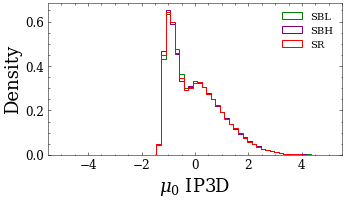

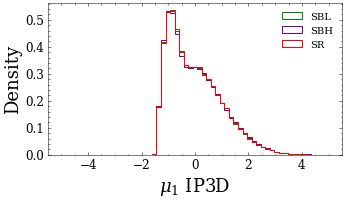

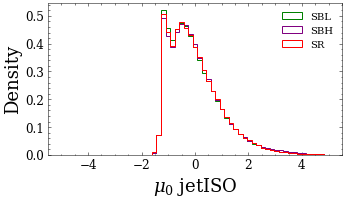

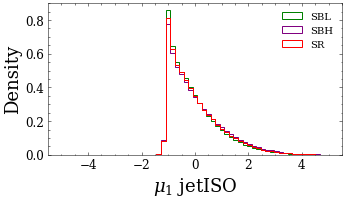

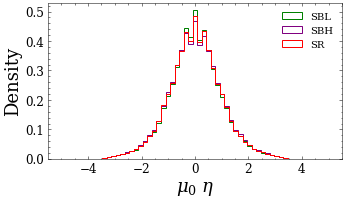

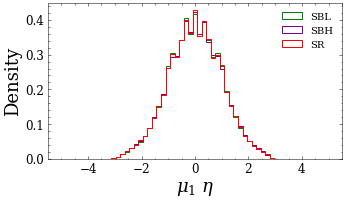

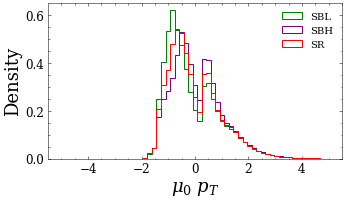

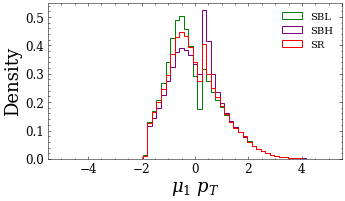

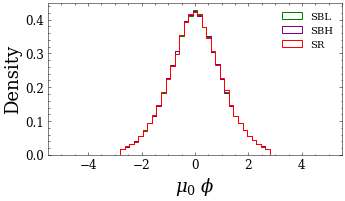

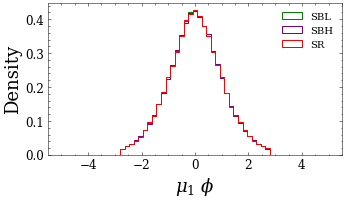

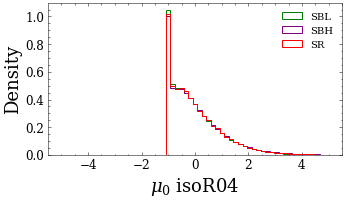

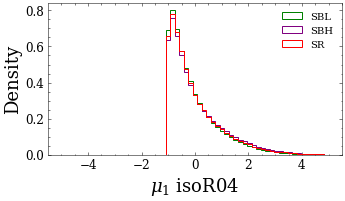

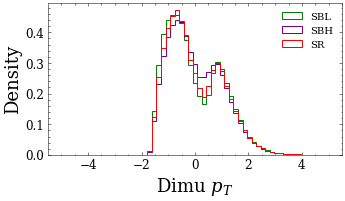

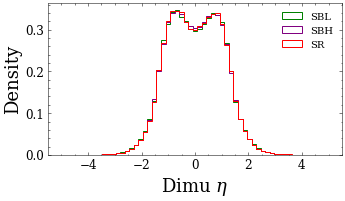

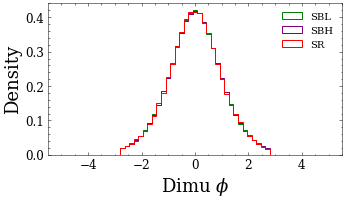

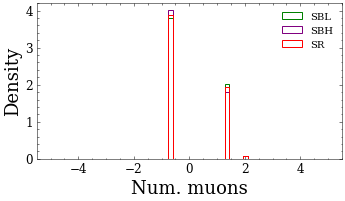

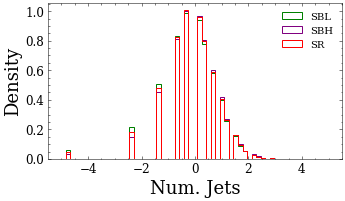

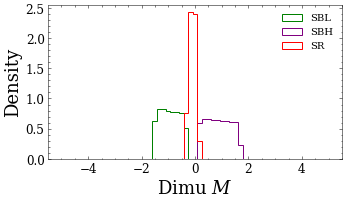

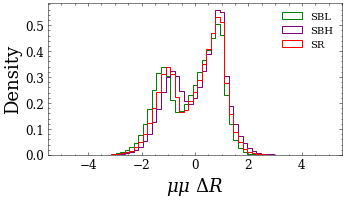

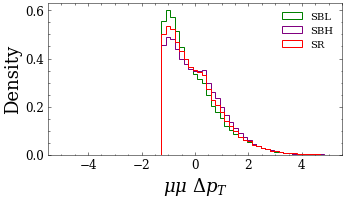

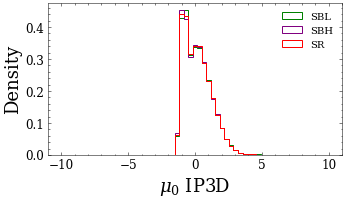

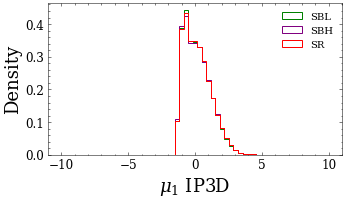

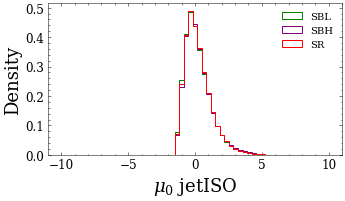

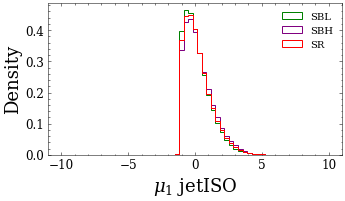

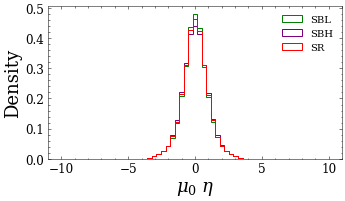

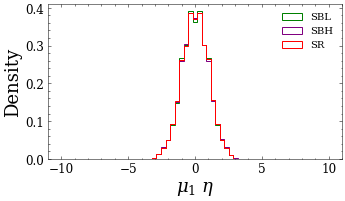

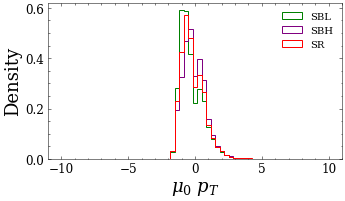

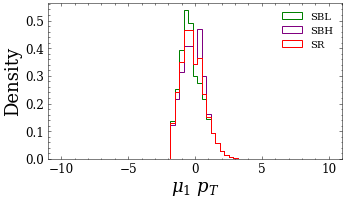

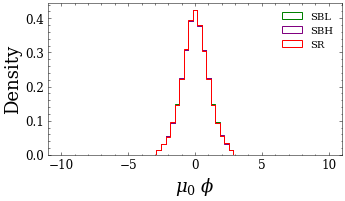

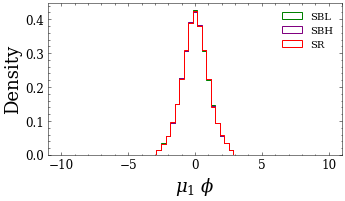

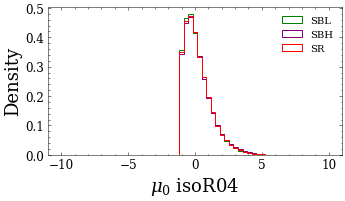

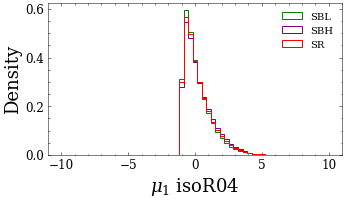

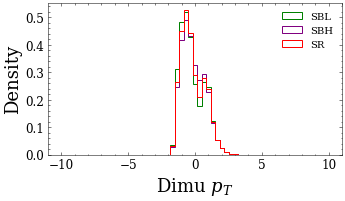

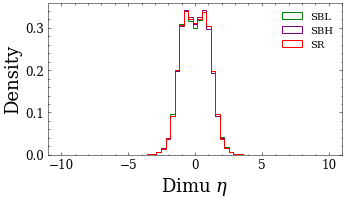

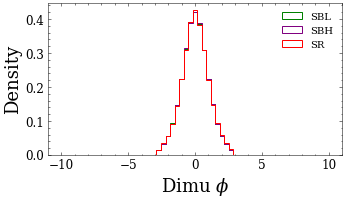

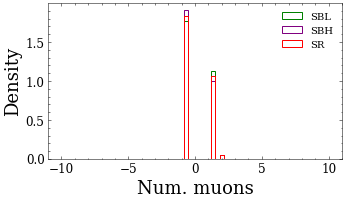

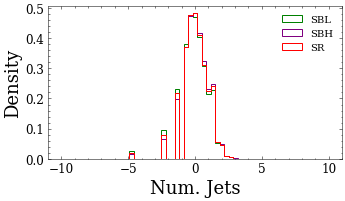

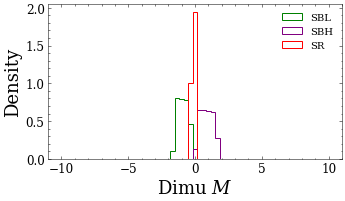

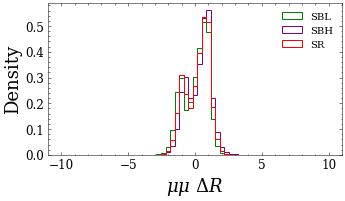

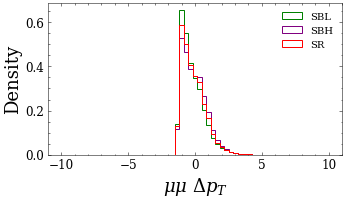

In [9]:
hist_all_features_dict([proccessed_data_dict["SBL"]["s_inj_data"], proccessed_data_dict["SBH"]["s_inj_data"], proccessed_data_dict["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=5, image_path=None, yscale_log=False, nice_labels=True)


hist_all_features_dict([proccessed_data_dict_samesign["SBL"]["s_inj_data"], proccessed_data_dict_samesign["SBH"]["s_inj_data"], proccessed_data_dict_samesign["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)





Create a batch script for flow training


In [15]:
feature_sets = workflow["feature_sets"]

if run_jet: jet_id = "jet"
else:jet_id = "nojet"

num_windows = len(bin_definitions.keys())
    
    
    
batches_to_run = ["single_3"]

with open("batch_lowmass_scan_05.sh", "w") as ofile:
    
    ofile.write("#!/bin/sh \n\n")
    ofile.write("#SBATCH -N 1\n")
    ofile.write("#SBATCH -C gpu\n")
    ofile.write("#SBATCH -G 1\n")
    ofile.write("#SBATCH -q regular\n")
    ofile.write("#SBATCH --job-name=lowmass_scan\n")
    ofile.write("#SBATCH --mail-user=rmastand@berkeley.edu\n")
    ofile.write("#SBATCH --mail-type=ALL\n")
    ofile.write("#SBATCH -t 5:00:00\n")
    ofile.write("#SBATCH -A m3246\n")
    ofile.write(f"#SBATCH --array=0-{2*num_windows-1}\n\n")
    ofile.write(f"declare -a commands=(\n")

    i = 0

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = '[{i}]="python 05_trueCATHODE.py -fid {feature_set} -f {feature_list},dimu_mass -pid lowmass_{window_index}_{jet_id} -c CATHODE_8 -seed 1 -did lowmass_scan -premade_bins -fit cubic"'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = i, jet_id = jet_id )
            #oc_command = 'python 05_trueCATHODE.py -fid {feature_set} -f {feature_list},dimu_mass -pid lowmass_{window_index}_{jet_id} -c CATHODE_8 -seed 1 -did lowmass_scan -premade_bins'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = i, jet_id = jet_id )

            ofile.write(loc_command)
            ofile.write("\n")
            loc_command = '[{i}]="python 05_trueCATHODE.py -fid {feature_set} -f {feature_list},dimu_mass -pid lowmass_{window_index}_samesign_{jet_id} -c CATHODE_8 -seed 1 -did lowmass_scan -premade_bins -fit cubic"'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = 2*i+1, jet_id = jet_id )
            ofile.write(loc_command)
            ofile.write("\n")
            i += 1

    ofile.write(f")\n")
    ofile.write(f"srun ${{commands[$SLURM_ARRAY_TASK_ID]}}")



In [ ]:
with open("batch_lowmass_scan_06.sh", "w") as ofile:

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = f'python 06_eval_CATHODE.py -f {fs} -p {window_index} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")
            loc_command = f'python 06_eval_CATHODE.py -f {fs} -p {window_index}_samesign -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")

In [ ]:
n_ensemble = 20
n_bootstrap = 1

with open("batch_lowmass_scan_07.sh", "w") as ofile:
    

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = f'python 07_bump_hunt_boostrap.py -f {fs} -p {window_index} -ne {n_ensemble} -nb {n_bootstrap} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")
            loc_command = f'python 07_bump_hunt_boostrap.py -f {fs} -p {window_index} -train_samesign -ne {n_ensemble} -nb {n_bootstrap} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            #ofile.write(loc_command+"\n")
            

    ofile.write(f"\n")

